In [89]:
import numpy as np
from scipy.special import lambertw
from scipy.optimize import fsolve, root_scalar

import matplotlib.pyplot as plt

from rikabplotlib.plot_utils import newplot, hist_with_errors, hist_with_outline, stamp

In [90]:
E0 = 500

beta = 1
R = 0.5

def alpha_s(scale):
    lambda_qcd = 0.2
    beta_0 = 11 - 2/3 * 3
    return 4 * np.pi / (beta_0 * np.log(scale**2 / lambda_qcd**2))

def LO_angularity(lambda_, beta = 1):

    scale = E0 * np.power(lambda_, 1 / (beta))

    alpha_s_scale = alpha_s(scale)
    C_F = 4/3
    C_A = 3

    return -(2 * alpha_s_scale * C_F / (1 * np.pi * beta * R)) * np.log(lambda_ ) / lambda_ 


def dalpha_dscale(scale):
    lambda_qcd = 0.2
    beta_0 = 11 - 2/3 * 3
    return -4 * np.pi / beta_0  / (np.log(scale**2 / lambda_qcd**2) ** 2) * 2 / scale




def df_dx(lambda_, beta = 1):

    lambda_qcd = 0.2
    beta_0 = 11 - 2/3 * 3

    scale = E0 * np.power(lambda_, 1 / (beta))
    alpha_s_scale = alpha_s(scale)

    C_F = 4/3


    dLO_dalpha =  -C_F / (beta * R *  np.pi) * np.power(np.log(lambda_), 2)
    dalpha_dscale = -4 * np.pi / beta_0  / (np.log(scale**2 / lambda_qcd**2) ** 2) * 2 / scale
    dscale_dlambda = E0

    return dLO_dalpha * dalpha_dscale * dscale_dlambda


def Theta(x):
    return 0.5 * (np.sign(x) + 1)
   

def LL_angularity(lambda_, beta = 1):

    scale = E0 * np.power(lambda_, 1 / (beta))

    alpha_s_scale = alpha_s(scale)
    C_F = 4/3
    C_A = 3

    p = np.nan_to_num(LO_angularity(lambda_, beta) * np.exp(-1 * alpha_s_scale * C_F / (beta * R *  np.pi) * np.power(np.log(lambda_), 2)) )

    return (p * Theta(lambda_) * Theta(1 - lambda_))



def LL_exact_angularity(lambda_, beta = 1):

    scale = E0 * np.power(lambda_, 1 / (beta))

    alpha_s_scale = alpha_s(scale)
    C_F = 4/3
    C_A = 3

    p = np.nan_to_num((LO_angularity(lambda_, beta) + df_dx(lambda_, beta)) * np.exp(-1 * alpha_s_scale * C_F / (beta * R *  np.pi) * np.power(np.log(lambda_), 2)) )

    return  (p * Theta(lambda_) * Theta(1 - lambda_)) * 1



# Lambert W Tests

In [108]:
def p(x):
    return LO_angularity(x) 

def C(x):
    return 1

def ReLU(x):
    return np.maximum(0, x)


def solved_q(p, C, x, lambda_ = None):

    p_x = p(x)
    q = p_x * np.exp(- lambertw(lambda_ * p_x / 2 / C(x), tol = 1e-12))

    return np.nan_to_num(q)

def solved_q_linear(p, C, x, lambda_ = None):

    return ReLU(p(x) - p(x)**2 * lambda_ / (2 * C(x)))



def solve_for_lambda(solved_q, p, C, x, verbose = False, MAX_ITER = 1000, lambda_init = 0.1):

    # def g(lambda_):
    #     return np.trapz(solved_q(p, C, x, lambda_).real, x) - 1
    
    # solved_lambda = fsolve(g, lambda_init, xtol = 1e-30, factor=0.1, maxfev=MAX_ITER)[0]
    # # solved_lambda = root_scalar(g, bracket=[-1, 1])

    # return solved_lambda


    integral_tolerance = 1e-3
    lambdas = np.linspace(0, lambda_init, 3)

    integral = 0
    iter = 0
    while np.abs(integral - 1) > integral_tolerance and iter < MAX_ITER:

        ys = solved_q(p, C, x[:, None], lambdas[None,:])
        integrals = np.trapz(ys.real, x, axis=0)
        integral = integrals[1]
        best_lamdbda = lambdas[1]

        # # Determine which side of the integral is closest to 1
        # if integrals[1] > 1 and integrals[2] <= 1:
        #     lambdas = np.linspace(lambdas[1], lambdas[2], 3)
        # elif integrals[1] < 1 and integrals[0] >= 1:
        #     lambdas = np.linspace(lambdas[0], lambdas[1], 3)
        
        # # If all integrals are less than 1, we need to shift the range to the right
        # elif integrals[0] < 1 and integrals[1] < 1 and integrals[2] < 1:
        #     lambdas = np.linspace(lambdas[0] * 10 , lambdas[2] * 10 , 3)

        # # If all integrals are greater than 1, we need to shift the range to the left
        # elif integrals[0] > 1 and integrals[1] > 1 and integrals[2] > 1:
        #     lambdas = np.linspace(lambdas[0] / 10, lambdas[2] / 10 , 3)


        # else:
        #     lambdas = np.linspace(lambdas[0] * 10, lambdas[2] * 10 , 3)


        # In the list of intergrals, find the one closest to 1
        closest_integral = np.argmin(np.abs(integrals - 1))
        integral = integrals[closest_integral]
        best_lamdbda = lambdas[closest_integral]

        # if the closest integral is the first or last, we need to expand the range
        if closest_integral == 0:
            lambdas = np.linspace(ReLU(lambdas[0] - lambdas[2]), lambdas[2], 5)
        elif closest_integral == len(lambdas) - 1:
            lambdas = np.linspace(lambdas[-3], lambdas[-1] + lambdas[-3], 5)
        else:
            lambdas = np.linspace(lambdas[closest_integral], lambdas[closest_integral + 1], 5)
        
        if verbose:
            # print(integral, lambdas[closest_integral], lambdas[closest_integral - 1], closest_integral)
            print(iter, lambdas, integrals)

            # print(integrals)

        iter += 1


    return best_lamdbda



# # Plot the LambertW function
# fig, ax = newplot("full")
# x = np.linspace(0, 1, 10000)
# y = lambertw(x)
# ax.plot(x, y.real)
# ax.set_yscale("log")
# integral = np.trapz(y.real, x)
# print("Integral of LambertW(x) from 0 to 1: ", integral)

# # Plot the LambertW function
# fig, ax = newplot("full")
# # x = np.linspace(0, 1, 10000)
# x = np.sort(np.random.rand(10000))
# lambdas = np.logspace(-1, 1, 1000)
# colors = plt.cm.viridis(np.linspace(0, 1, len(lambdas)))
# integrals = []
# for lambda_ in lambdas:
#     y = solved_q(p, C, x, lambda_)
#     ax.plot(x, y.real, label=f"$\lambda$ = {lambda_}", color=colors[np.where(lambdas == lambda_)[0][0]])
#     integral = np.trapz(y.real, x)
#     integrals.append(integral)

# solved_lambda = solve_for_lambda(solved_q, p, C, x)
# print("Solved lambda: ", solved_lambda)

# ax.plot(x, LO_angularity(x), color="black") 
# ax.plot(x, solved_q(p, C, x, 0.5), color="red")  
# ax.set_yscale("log")


# # Plot the integrals
# fig, ax = newplot("full")
# integrals = np.array(integrals)
# signed_color = (np.sign(integrals) + 1) / 2
# ax.plot(lambdas[integrals > 0], np.abs(integrals[integrals > 0]), color = "red")
# ax.plot(lambdas[integrals < 0], np.abs(integrals[integrals < 0]), color = "blue")

# ax.set_yscale("log")
# ax.set_xscale("log")
# ax.set_xlabel("$\lambda$")
# ax.set_ylabel("Abs(Integral)")



# Hard Cutoff Plots

/tmp/ipykernel_4356/1373564452.py:17: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = get_cmap("jet_r")


c =  0.99 solved_lambda =  5.969011848229741e-43
c =  0.88 solved_lambda =  2.617227934608645e-38
c =  0.77 solved_lambda =  1.5518342477366743e-33
c =  0.66 solved_lambda =  9.309091703280616e-29
c =  0.55 solved_lambda =  5.605933433452328e-24
c =  0.44 solved_lambda =  3.3701885109922374e-19
c =  0.33 solved_lambda =  1.9953231255736963e-14
c =  0.22 solved_lambda =  1.201320508500102e-09
c =  0.11 solved_lambda =  7.153831083996922e-05
c =  0.0 solved_lambda =  0.023856232982333834


/tmp/ipykernel_4356/1373564452.py:65: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.colorbar(sm, label="Cutoff")
/tmp/ipykernel_4356/1373564452.py:17: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = get_cmap("jet_r")


c =  0.99 solved_lambda =  3.8381589529590286e-42
c =  0.88 solved_lambda =  1.657292817052066e-37
c =  0.77 solved_lambda =  9.9804934849044e-33
c =  0.66 solved_lambda =  6.017191311443815e-28
c =  0.55 solved_lambda =  3.5793477533264823e-23
c =  0.44 solved_lambda =  2.1379633366607006e-18
c =  0.33 solved_lambda =  1.2837634501045583e-13
c =  0.22 solved_lambda =  7.64663372621044e-09
c =  0.11 solved_lambda =  0.0004593689722241836
c =  0.0 solved_lambda =  0.15286434888839723


/tmp/ipykernel_4356/1373564452.py:65: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.colorbar(sm, label="Cutoff")


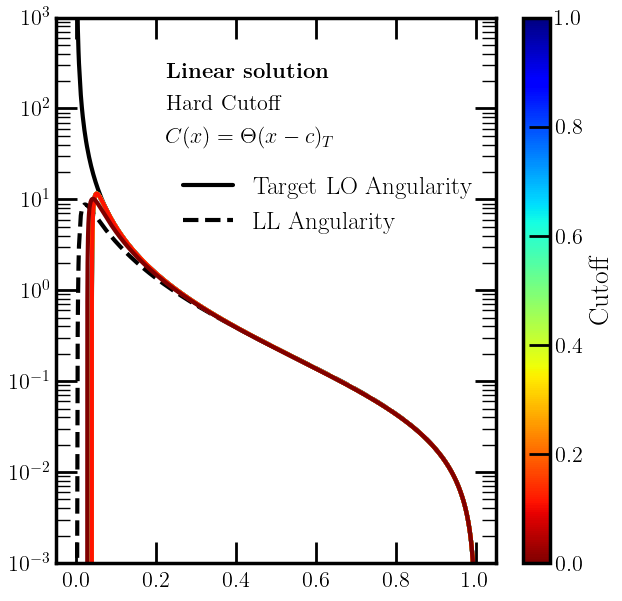

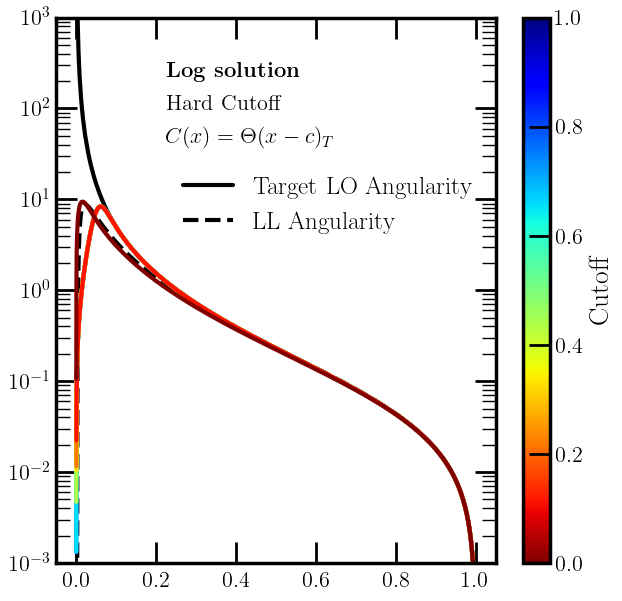

In [109]:
from matplotlib.cm import get_cmap


# cs = np.linspace(0, 1, 10)

solution_types = {"Log", "Linear"}
solved_qs = {'Log': solved_q, 'Linear': solved_q_linear}

for solution_type in solution_types:


    fig, ax = newplot("full")
    N_samples = 1000
    x = np.sort(np.random.uniform(0, 1, N_samples))

    cs = np.linspace(0, 0.99, 10)[::-1]
    colors = get_cmap("jet_r")
    ys = []


    ax.plot(x, LO_angularity(x), color="black", label = "Target LO Angularity")
    ax.plot(x, LL_exact_angularity(x, beta = 1), color="black", linestyle="--", label = "LL Angularity")




    for c in cs:

        N_samples = 10000
        x = np.sort(np.random.uniform(0, 1, N_samples))

        def p(x):
            return LO_angularity(x) 
        
        def sigmoid(x):
            return 1 / (1 + np.exp(-x))

        def C(x):
            z = (x - c) / 0.01
            z0 = (0 - c) / 0.01
            z1 = (1 - c) / 0.01
            return (sigmoid(z) - sigmoid(z0)) / (sigmoid(z1) )
        

        # ax.plot(x, C(x), label=f"c = {c}", color=colors(1-c))

        solved_q_function = solved_qs[solution_type]
        solved_lambda = solve_for_lambda(solved_q_function, p, C, x, verbose = False)
        y = np.nan_to_num(solved_q_function(p, C, x, solved_lambda)).real
        ys.append(y)
        ax.plot(x, y, color=colors(c))
        ax.set_yscale("log")
        ax.set_ylim(1e-3, 1e3)

        np.save(f"plotfiles/exact_theta_ys_{cs}.npy", np.array([x, y]))


        print("c = ", c, "solved_lambda = ", solved_lambda)

    line_0 = f"{solution_type} solution"
    line_1 = f"Hard Cutoff"
    line_2 = f"$C(x) = \Theta(x - c)_T $ "
    stamp(0.25, 0.9, ax, line_0 = line_0, line_1 = line_1, line_2 = line_2)

    # Add a colorbar
    sm = plt.cm.ScalarMappable(cmap=plt.get_cmap("jet_r"), norm=plt.Normalize(vmin=0, vmax=1))
    sm.set_array([])
    plt.colorbar(sm, label="Cutoff")

    plt.legend(bbox_to_anchor=(1.0, 0.75))


# $\alpha_s $ Cutoff Plots

/tmp/ipykernel_4356/3009210272.py:17: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = get_cmap("jet_r")


x_c =  0.99 c =  140.65192215005024 solved_lambda =  9.969135832268651e-08 integral =  16.151438789081517
x_c =  0.8911 c =  138.75745295687094 solved_lambda =  1.9804962480551806e-15 integral =  56.605096494236534
x_c =  0.7922 c =  136.63988310711548 solved_lambda =  1.9896951274323944e-17 integral =  43.71080941334046
x_c =  0.6933 c =  134.2395636808068 solved_lambda =  9.112935811507186e-07 integral =  12.310204202698946
x_c =  0.5944 c =  131.46917805499868 solved_lambda =  0.1078125 integral =  0.9997136293080586
x_c =  0.4955 c =  128.19344554159557 solved_lambda =  1.1099737982290454e-09 integral =  25.894834093484494
x_c =  0.3966 c =  124.18594106327733 solved_lambda =  3.5275115575659068e-09 integral =  27.071732017767424
x_c =  0.2977 c =  119.02278599812594 solved_lambda =  8.786128034481043e-14 integral =  22.6019590614637
x_c =  0.1988 c =  111.75462046973932 solved_lambda =  2.3638367892074415e-16 integral =  49.59397309989149
x_c =  0.0999 c =  99.36828751551595 solve

/tmp/ipykernel_4356/3009210272.py:68: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.colorbar(sm, label="Cutoff")
/tmp/ipykernel_4356/3009210272.py:17: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = get_cmap("jet_r")


x_c =  0.99 c =  140.65192215005024 solved_lambda =  0.6519531249999999 integral =  0.999849541420291
x_c =  0.8911 c =  138.75745295687094 solved_lambda =  0.6615534721603603 integral =  0.9992863142462161
x_c =  0.7922 c =  136.63988310711548 solved_lambda =  0.6695778786303141 integral =  0.9993998864653569
x_c =  0.6933 c =  134.2395636808068 solved_lambda =  0.6751817934215067 integral =  1.000488975012628
x_c =  0.5944 c =  131.46917805499868 solved_lambda =  0.6937499999999999 integral =  1.0004943287925503
x_c =  0.4955 c =  128.19344554159557 solved_lambda =  0.7105305474484338 integral =  1.000139937307964
x_c =  0.3966 c =  124.18594106327733 solved_lambda =  0.7320416742021059 integral =  1.000689029812022
x_c =  0.2977 c =  119.02278599812594 solved_lambda =  0.7660491943359374 integral =  0.9991556749777372
x_c =  0.1988 c =  111.75462046973932 solved_lambda =  0.8090895578367961 integral =  1.000157767484402
x_c =  0.0999 c =  99.36828751551595 solved_lambda =  0.9062300

/tmp/ipykernel_4356/3009210272.py:68: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.colorbar(sm, label="Cutoff")


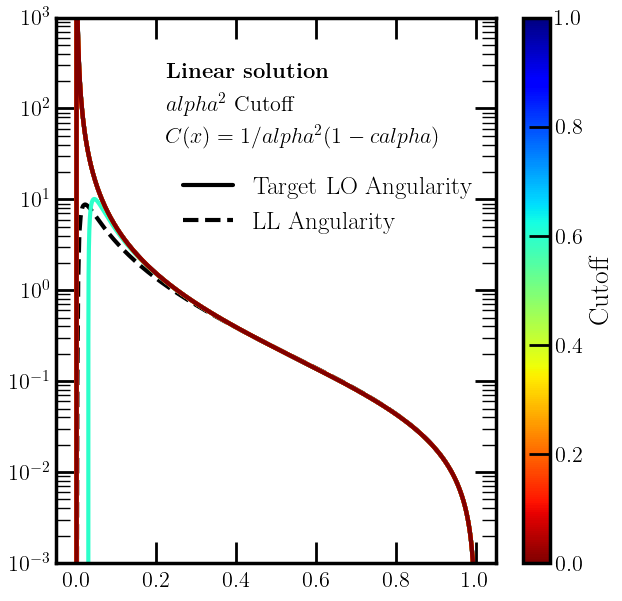

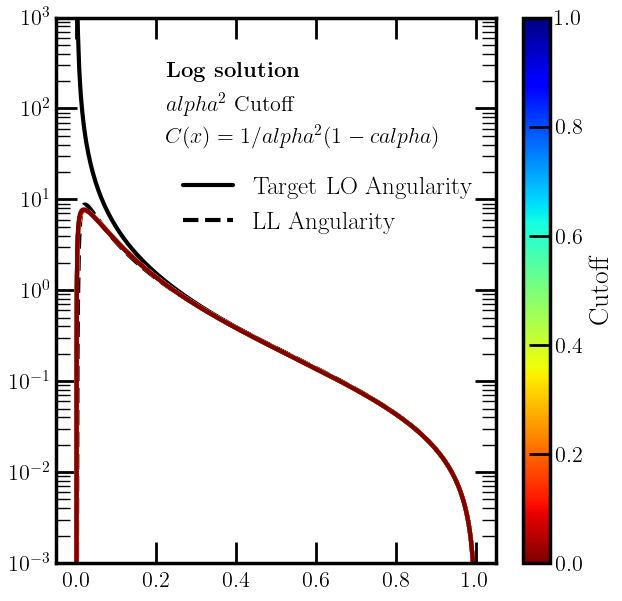

In [110]:
from matplotlib.cm import get_cmap


# cs = np.linspace(0, 1, 10)

solution_types = {"Log", "Linear"}
solved_qs = {'Log': solved_q, 'Linear': solved_q_linear}

for solution_type in solution_types:


    fig, ax = newplot("full")
    N_samples = 1000
    x = np.sort(np.random.uniform(0, 1, N_samples))

    cs = np.linspace(0.001, 0.99, 11)[::-1]
    colors = get_cmap("jet_r")
    ys = []


    ax.plot(x, LO_angularity(x), color="black", label = "Target LO Angularity")
    ax.plot(x, LL_exact_angularity(x, beta = 1), color="black", linestyle="--", label = "LL Angularity")



    for c in cs:

        N_samples = 10000
        x = np.sort(np.random.uniform(0, 1, N_samples))

        c_x = 4 * np.pi / (alpha_s(E0 * c))


        def p(x):
            return LO_angularity(x) 
        
        def sigmoid(x):
            return 1 / (1 + np.exp(-x))

        def C(x):
            beta = 1
            alpha_s_scale = alpha_s(E0 * np.power(x, 1 / beta))
            return 1 / (alpha_s_scale**2 + c_x *  alpha_s_scale**3)  
        

        # ax.plot(x, C(x), label=f"c = {c}", color=colors(1-c))

        solved_q_function = solved_qs[solution_type]
        solved_lambda = solve_for_lambda(solved_q_function, p, C, x, verbose = False)
        y = np.nan_to_num(solved_q_function(p, C, x, solved_lambda))
        ys.append(y)
        ax.plot(x, y.real, color=colors(c))
        ax.set_yscale("log")
        ax.set_ylim(1e-3, 1e3)

        integral = np.trapz(y.real, x)

        print("x_c = ", c,"c = ", c_x, "solved_lambda = ", solved_lambda, "integral = ", integral)

    line_0 = f"{solution_type} solution"
    line_1 = r"$alpha^2$ Cutoff"
    line_2 = r"$C(x) = 1 / alpha^2 (1 - c alpha)$ "
    stamp(0.25, 0.9, ax, line_0 = line_0, line_1 = line_1, line_2 = line_2)

    # Add a colorbar
    sm = plt.cm.ScalarMappable(cmap=plt.get_cmap("jet_r"), norm=plt.Normalize(vmin=0, vmax=1))
    sm.set_array([])
    plt.colorbar(sm, label="Cutoff")

    plt.legend(bbox_to_anchor=(1.0, 0.75))


/tmp/ipykernel_4356/2664790445.py:17: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = get_cmap("jet_r")


x_c =  0.99 c =  13854.800969664815 solved_lambda =  2.8936280224344086e-25 integral =  24.074155587797378
x_c =  0.8911 c =  1072.4045235794695 solved_lambda =  3.192721587475991e-23 integral =  27.293024711368595
x_c =  0.7922 c =  464.6924860981749 solved_lambda =  1.1841261760238897e-23 integral =  31.768454771286017
x_c =  0.6933 c =  254.08190544866247 solved_lambda =  4.0996237632976325e-26 integral =  25.25756333577853
x_c =  0.5944 c =  150.22080158408866 solved_lambda =  6.488483934425511e-22 integral =  29.284348425755862
x_c =  0.4955 c =  90.45990394476601 solved_lambda =  7.881654677717252e-23 integral =  23.525008019297207
x_c =  0.3966 c =  53.255517925096505 solved_lambda =  2.0480423670492447e-21 integral =  25.39175200532662
x_c =  0.2977 c =  29.24320344180193 solved_lambda =  2.6653520676774746e-21 integral =  21.433392471213953
x_c =  0.1988 c =  13.752661018919342 solved_lambda =  4.089251419851281e-23 integral =  37.52613405401243
x_c =  0.0999 c =  4.3093219334

/tmp/ipykernel_4356/2664790445.py:69: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.colorbar(sm, label="Cutoff")
/tmp/ipykernel_4356/2664790445.py:17: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = get_cmap("jet_r")


x_c =  0.99 c =  13854.800969664815 solved_lambda =  1.561973223499421e-08 integral =  1.0003868395683966
x_c =  0.8911 c =  1072.4045235794695 solved_lambda =  2.026955330705627e-07 integral =  0.9998172053641347
x_c =  0.7922 c =  464.6924860981749 solved_lambda =  4.70178365172963e-07 integral =  0.9991577145840995
x_c =  0.6933 c =  254.08190544866247 solved_lambda =  8.555733513659903e-07 integral =  0.9997682351013575
x_c =  0.5944 c =  150.22080158408866 solved_lambda =  1.4423288626363649e-06 integral =  1.0001458793505789
x_c =  0.4955 c =  90.45990394476601 solved_lambda =  2.38449101743754e-06 integral =  1.0006458852526532
x_c =  0.3966 c =  53.255517925096505 solved_lambda =  4.081561201019213e-06 integral =  0.9995782891877143
x_c =  0.2977 c =  29.24320344180193 solved_lambda =  7.446865420113189e-06 integral =  0.9991338340241757
x_c =  0.1988 c =  13.752661018919342 solved_lambda =  1.5690892406183815e-05 integral =  0.999759429332537
x_c =  0.0999 c =  4.3093219334039

/tmp/ipykernel_4356/2664790445.py:69: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.colorbar(sm, label="Cutoff")


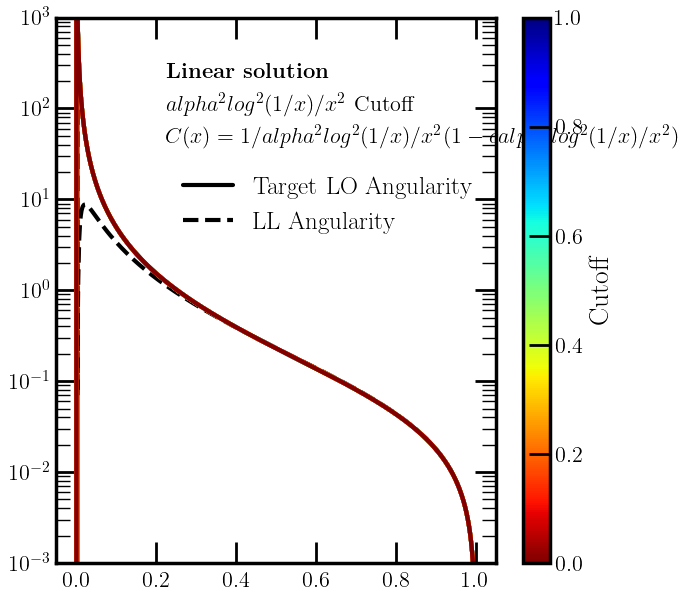

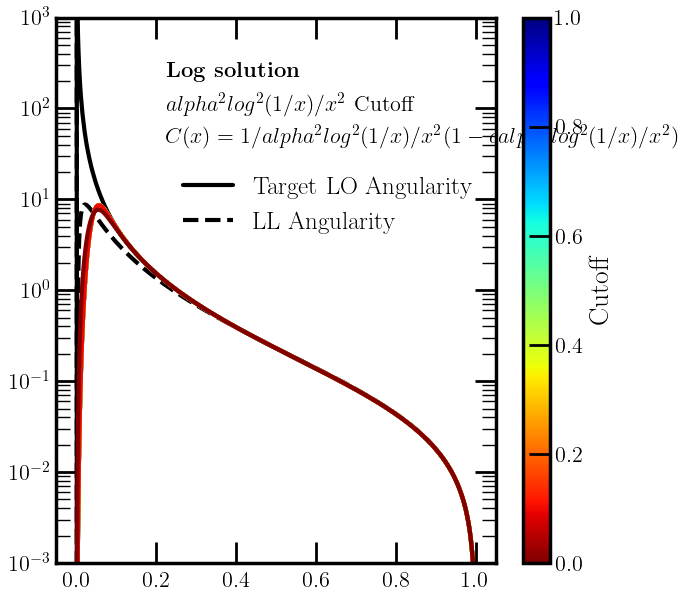

In [111]:
from matplotlib.cm import get_cmap


# cs = np.linspace(0, 1, 10)

solution_types = {"Log", "Linear"}
solved_qs = {'Log': solved_q, 'Linear': solved_q_linear}

for solution_type in solution_types:


    fig, ax = newplot("full")
    N_samples = 1000
    x = np.sort(np.random.uniform(0, 1, N_samples))

    cs = np.linspace(0.001, 0.99, 11)[::-1]
    colors = get_cmap("jet_r")
    ys = []


    ax.plot(x, LO_angularity(x), color="black", label = "Target LO Angularity")
    ax.plot(x, LL_exact_angularity(x, beta = 1), color="black", linestyle="--", label = "LL Angularity")



    for c in cs:

        N_samples = 10000
        x = np.sort(np.random.uniform(0, 1, N_samples))

        c_x = 4 * np.pi / (alpha_s(E0 * c) * np.log(1/c) / c)


        def p(x):
            return LO_angularity(x) 
        
        def sigmoid(x):
            return 1 / (1 + np.exp(-x))

        def C(x):
            beta = 1
            alpha_s_scale = alpha_s(E0 * np.power(x, 1 / beta))
            alpha_s_log = alpha_s_scale * np.log(1/x) / x
            return 1 / (alpha_s_log**2 + c_x *  alpha_s_log**3)  
        

        # ax.plot(x, C(x), label=f"c = {c}", color=colors(1-c))

        solved_q_function = solved_qs[solution_type]
        solved_lambda = solve_for_lambda(solved_q_function, p, C, x, verbose = False)
        y = np.nan_to_num(solved_q_function(p, C, x, solved_lambda))
        ys.append(y)
        ax.plot(x, y.real, color=colors(c))
        ax.set_yscale("log")
        ax.set_ylim(1e-3, 1e3)

        integral = np.trapz(y.real, x)

        print("x_c = ", c,"c = ", c_x, "solved_lambda = ", solved_lambda, "integral = ", integral)

    line_0 = f"{solution_type} solution"
    line_1 = r"$alpha^2 log^2(1/x) / x^2$ Cutoff"
    line_2 = r"$C(x) = 1 / alpha^2 log^2(1/x)/x^2(1 - c alpha log^2(1/x)/x^2)$ "
    stamp(0.25, 0.9, ax, line_0 = line_0, line_1 = line_1, line_2 = line_2)

    # Add a colorbar
    sm = plt.cm.ScalarMappable(cmap=plt.get_cmap("jet_r"), norm=plt.Normalize(vmin=0, vmax=1))
    sm.set_array([])
    plt.colorbar(sm, label="Cutoff")

    plt.legend(bbox_to_anchor=(1.0, 0.75))


/tmp/ipykernel_4356/1321964651.py:25: RuntimeWarning: invalid value encountered in log
  C = - p(x) * R_x / (2 * np.log(R_x))


x_c =  0.8911 c =  1072.4045235794695 solved_lambda =  0.9983696904033423 integral =  1.0005492414122914


/tmp/ipykernel_4356/1321964651.py:50: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.colorbar(sm, label="Cutoff")


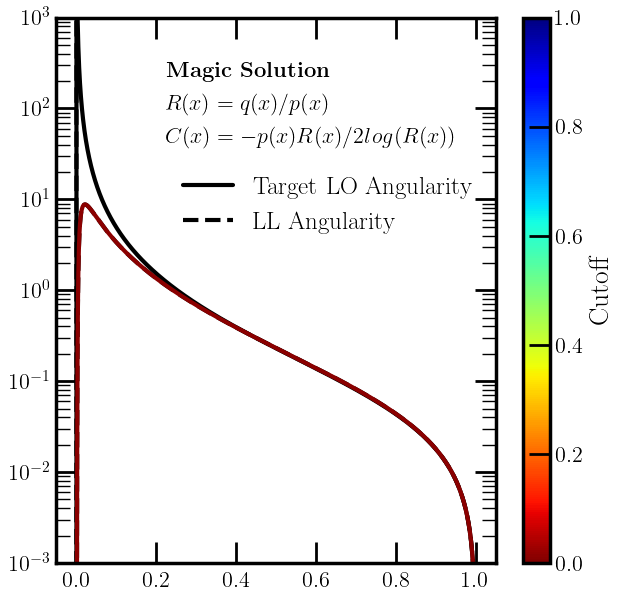

In [119]:
from matplotlib.cm import get_cmap


# cs = np.linspace(0, 1, 10)

fig, ax = newplot("full")
N_samples = 10000
x = np.sort(np.random.uniform(0, 1, N_samples))

ax.plot(x, LO_angularity(x), color="black", label = "Target LO Angularity")
ax.plot(x, LL_exact_angularity(x, beta = 1), color="black", linestyle="--", label = "LL Angularity")



def p(x):
    return LO_angularity(x) 

def q(x):
    # return 2 * x
    return LL_exact_angularity(x, beta = 1)

def C(x):

    R_x = q(x) / p(x)
    C = - p(x) * R_x / (2 * np.log(R_x))

    return C


solved_q_function = solved_q
solved_lambda = solve_for_lambda(solved_q_function, p, C, x, verbose = False)
y = np.nan_to_num(solved_q_function(p, C, x, solved_lambda))
ax.plot(x, y.real, color="darkred")
ax.set_yscale("log")
ax.set_ylim(1e-3, 1e3)

integral = np.trapz(y.real, x)

print("x_c = ", c,"c = ", c_x, "solved_lambda = ", solved_lambda, "integral = ", integral)


line_0 = f"Magic Solution"
line_1 = r"$R(x) = q(x) / p(x)$ "
line_2 = r"$C(x) = -p(x)R(x) / 2 log(R(x))$ "
stamp(0.25, 0.9, ax, line_0 = line_0, line_1 = line_1, line_2 = line_2)

# Add a colorbar
sm = plt.cm.ScalarMappable(cmap=plt.get_cmap("jet_r"), norm=plt.Normalize(vmin=0, vmax=1))
sm.set_array([])
plt.colorbar(sm, label="Cutoff")

plt.legend(bbox_to_anchor=(1.0, 0.75))



c =  0.99 integral =  0.9742430359860217
[7.04557130e-05 7.58452856e-05 1.30335128e-04 1.59739482e-04
 3.74042051e-04 4.01016649e-04 9.08992570e-04 9.26502228e-04
 1.01807024e-03 1.06796414e-03] [-1.92697816e-10+0.j -2.49137323e-09+0.j -9.48049931e-10+0.j
  1.49133437e-08+0.j  5.98909631e-08+0.j  1.96781533e-07+0.j
  2.18197057e-07+0.j  2.06284774e-06+0.j  2.31809085e-06+0.j
  3.05506003e-06+0.j]
c =  0.8911 integral =  0.9574900610644517
[7.04557130e-05 7.58452856e-05 1.30335128e-04 1.59739482e-04
 3.74042051e-04 4.01016649e-04 9.08992570e-04 9.26502228e-04
 1.01807024e-03 1.06796414e-03] [-2.23265894e-12+0.j -1.54008456e-09+0.j -1.85756330e-09+0.j
 -3.68560357e-09+0.j -1.16536864e-09+0.j -2.47138314e-10+0.j
  3.11950214e-14+0.j  6.71549992e-10+0.j  1.48257337e-07+0.j
  1.87062813e-07+0.j]
c =  0.7922 integral =  0.9890235966551707
[7.04557130e-05 7.58452856e-05 1.30335128e-04 1.59739482e-04
 3.74042051e-04 4.01016649e-04 9.08992570e-04 9.26502228e-04
 1.01807024e-03 1.06796414e-03] [

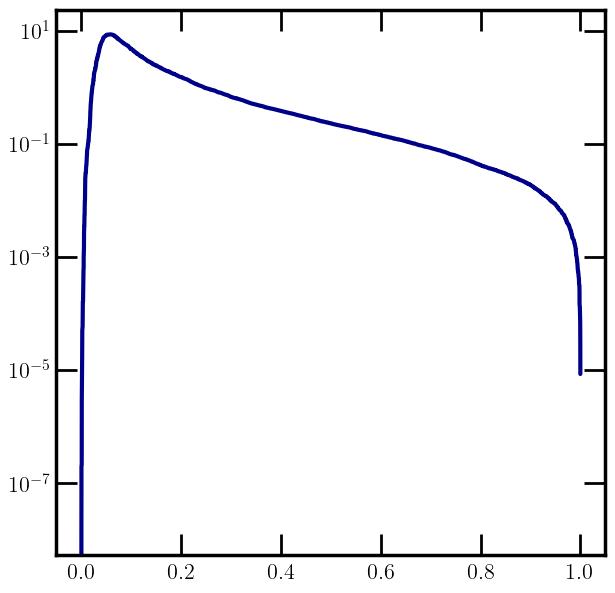

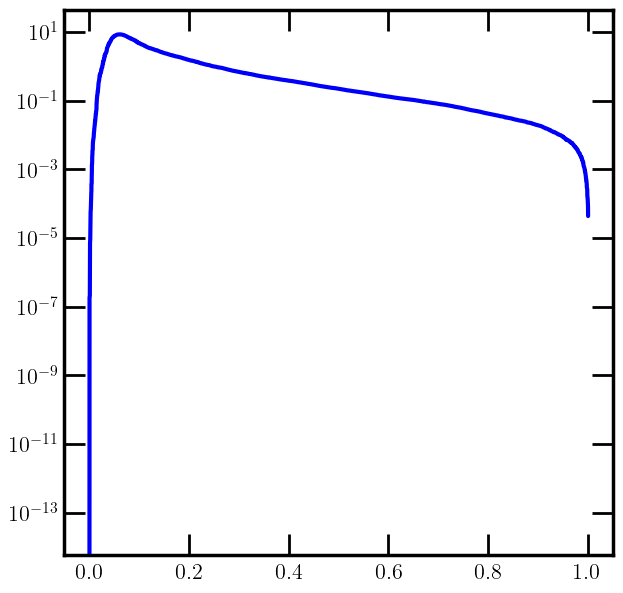

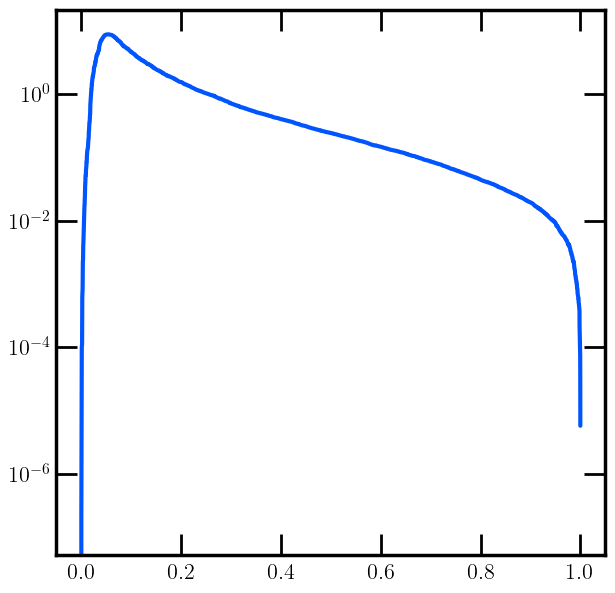

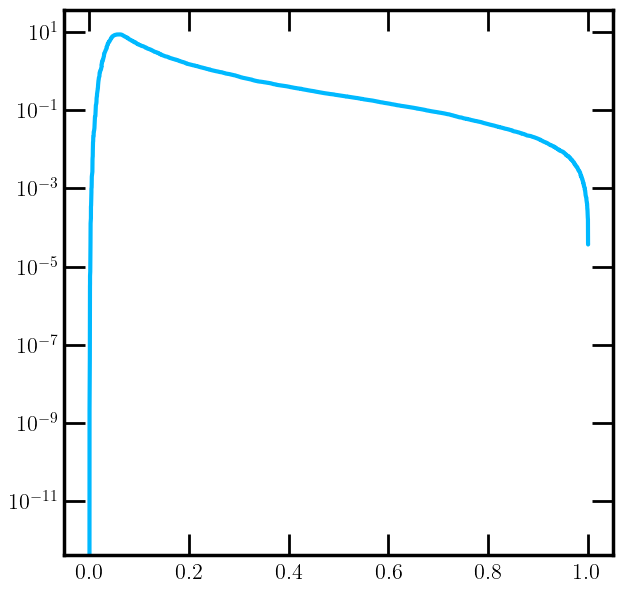

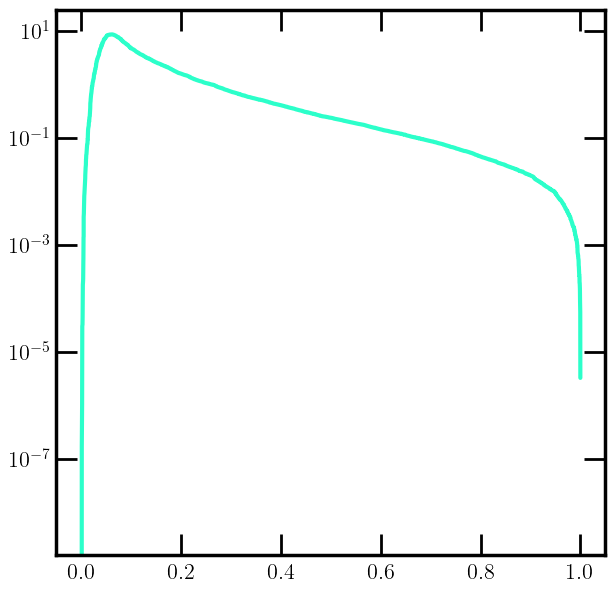

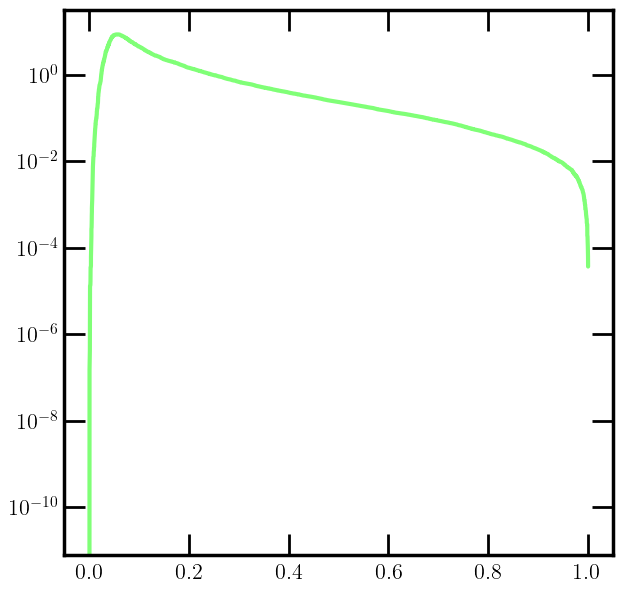

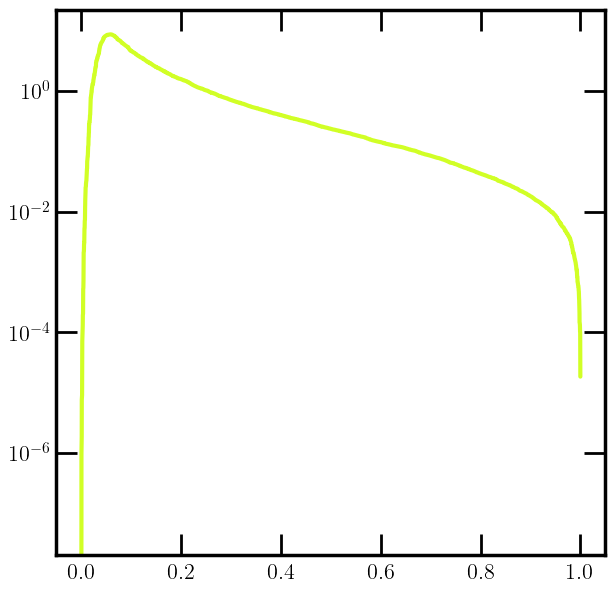

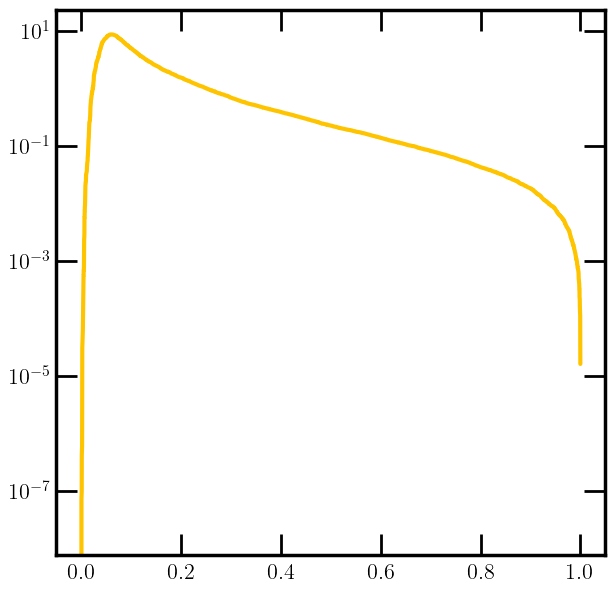

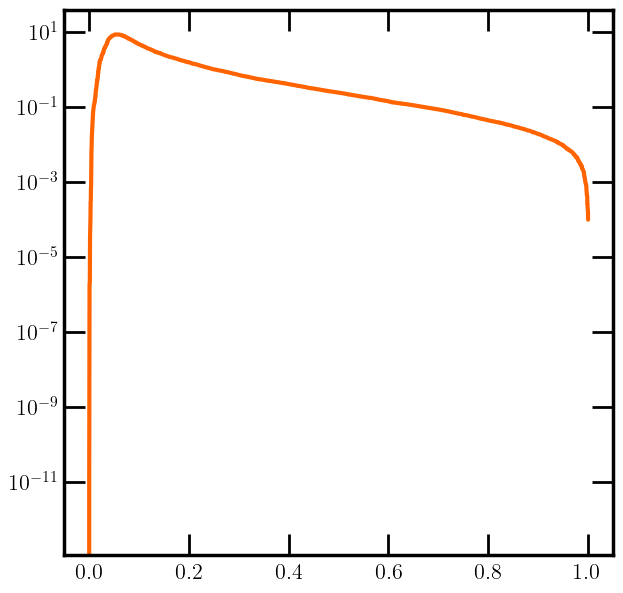

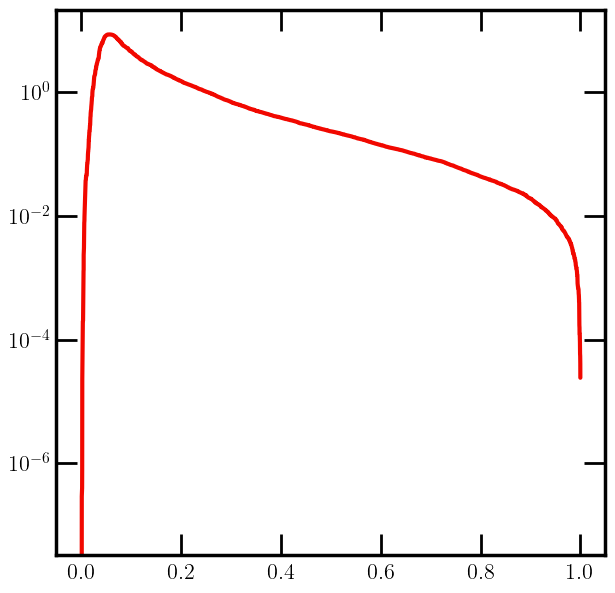

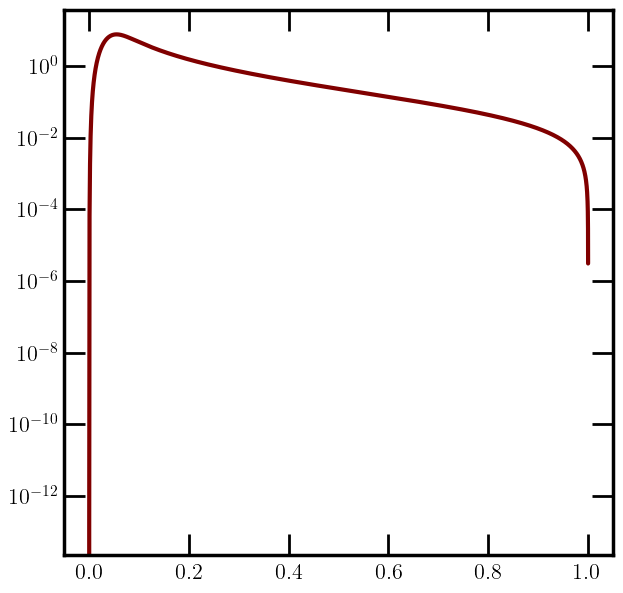

In [112]:
for (i, c) in enumerate(cs):

    # fig, ax = newplot("full")

    # def C(x):
    #     z = (x - c) / 0.01
    #     z0 = (0 - c) / 0.01
    #     z1 = (1 - c) / 0.01
    #     return (sigmoid(z) - sigmoid(z0)) / (sigmoid(z1) )
    
    # ax.plot(x, C(x), label=f"c = {c}", color=colors(1-c))

    fig, ax = newplot("full")
    ax.plot(x, ys[i].real, label=f"c = {c}", color=colors(c))
    ax.set_yscale("log")

    integral = np.trapz(ys[i].real, x)
    print("c = ", c, "integral = ", integral)
    print(x[:10], ys[i][:10])



# Junk

In [95]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def p_x(x):
    return -np.log(x) / x

p_x = LO_angularity

def C(x, c = 0.5, temp = 0.001):

    return sigmoid((x - c) / temp) - sigmoid((0 - c) / temp)



def ReLU(x):
    return np.maximum(0, x)

N_samples = 100000
x = np.random.uniform(0, 1, N_samples)

def answer(p, C, x, lambda_ = None, c = 0.5):

    # log MSE
    arg = lambda_ * p(x) / (2 * C(x, c) )
    q = p(x) * np.exp(lambertw(-arg, tol = 1e-12))
    return(q)

    # ratio MSE
    return ReLU(p(x) - p(x)**2 * lambda_ / (2 * C(x, c)))


def integral(p, C, x, lambda_ = None, c = 0.5):

    ans = answer(p, C, x, lambda_, c)
    return np.mean(ans)

def find_lambda(c = 0.5):

    tolerance = 1e-5

    max_lambda = 2 * C(x, c) * p_x(x)

    # Take the minimum of the max_lambda
    max_lambda = np.max(max_lambda) 
    min_lambda = - max_lambda

    s_max = integral(p_x, C, x, max_lambda, c)
    s_min = integral(p_x, C, x, min_lambda, c)

    mid_lambda = (max_lambda + min_lambda) / 2 
    s_mid = integral(p_x, C, x, mid_lambda, c)

    while np.abs(s_mid - 1) > tolerance:
        if s_mid > 1:
            min_lambda = mid_lambda
        else:
            max_lambda = mid_lambda

        mid_lambda = (max_lambda + min_lambda) / 2
        s_mid = integral(p_x, C, x, mid_lambda, c)

    return mid_lambda


In [96]:
print(np.sort(x))

[1.80205503e-05 2.06829476e-05 2.24328697e-05 ... 9.99990483e-01
 9.99993996e-01 9.99999807e-01]


/tmp/ipykernel_4356/1791143491.py:2: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-x))


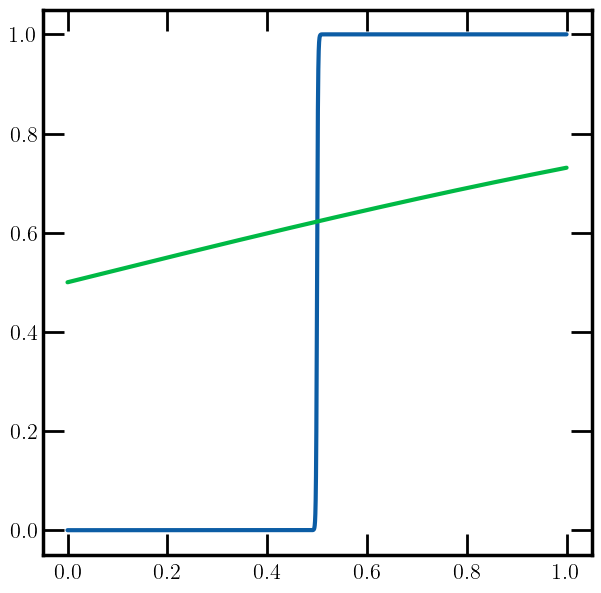

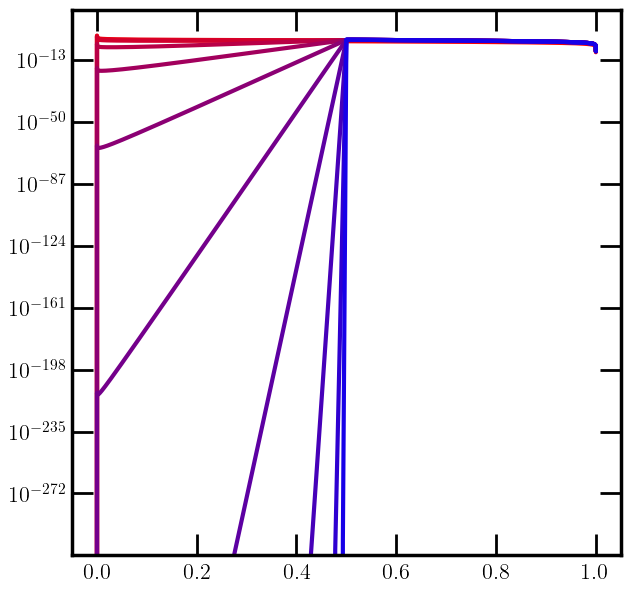

In [97]:
fig, ax = newplot("full")
x_sorted = np.sort(x)
ax.plot(x_sorted, C(x_sorted), label = "C(x)")
ax.plot(x_sorted, sigmoid(x_sorted), label = "p(x)")
# ax.plot(x_sorted, p_x(x_sorted), label = "p(x)")


fig, ax = newplot("full")
for (i,temp) in enumerate(np.logspace(-5, 0, 11)[::-1]):

    # warm to cool color
    n = 11
    color = (1 - i/n, 0, i/n)
   
    ratio = p_x(x_sorted) * C(x_sorted, temp=temp)
    ax.plot(x_sorted, ratio, label = "p(x) / C(x)", color = color)
    ax.set_yscale("log")
    # ax.set_xscale("log")

/tmp/ipykernel_4356/1778562690.py:10: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = get_cmap("jet")
/tmp/ipykernel_4356/1791143491.py:2: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-x))
/tmp/ipykernel_4356/1791143491.py:24: RuntimeWarning: divide by zero encountered in true_divide
  arg = lambda_ * p(x) / (2 * C(x, c) )
/tmp/ipykernel_4356/1791143491.py:25: RuntimeWarning: invalid value encountered in multiply
  q = p(x) * np.exp(lambertw(-arg, tol = 1e-12))
/tmp/ipykernel_4356/1791143491.py:24: RuntimeWarning: invalid value encountered in true_divide
  arg = lambda_ * p(x) / (2 * C(x, c) )
/home/rikab/miniconda3/envs/SHAPER/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x,

1.0 (nan+nanj)
0.9500000000000001 (nan+nanj)
0.9 (nan+nanj)
0.8500000000000001 (nan+nanj)
0.8 (nan+nanj)


/tmp/ipykernel_4356/1791143491.py:24: RuntimeWarning: overflow encountered in true_divide
  arg = lambda_ * p(x) / (2 * C(x, c) )


0.75 (nan+nanj)


/tmp/ipykernel_4356/1791143491.py:25: RuntimeWarning: overflow encountered in multiply
  q = p(x) * np.exp(lambertw(-arg, tol = 1e-12))
/home/rikab/miniconda3/envs/SHAPER/lib/python3.8/site-packages/numpy/core/_methods.py:179: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)


0.7000000000000001 (nan+nanj)


KeyboardInterrupt: 

/home/rikab/miniconda3/envs/SHAPER/lib/python3.8/site-packages/matplotlib/scale.py:253: RuntimeWarning: overflow encountered in power
  return np.power(self.base, a)


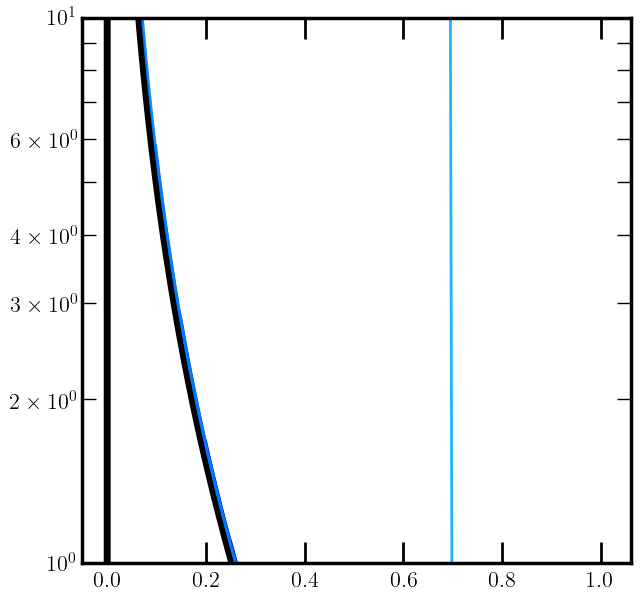

In [98]:
import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap

fig, ax = newplot("full")

ax.plot(x_sorted, p_x(x_sorted), label = "p(x)", color = "black", lw = 5)


cs = np.linspace(0, 1.0, 21)[::-1]
colors = get_cmap("jet")

for c in cs:




    lambda_ = find_lambda(c)
    ax.plot(x_sorted + c / 100, answer(p_x, C, x_sorted, lambda_, c), label = "answer", color = colors(1-c), alpha = 0.9, lw = 2)


    ax.set_yscale("log")
# print(answer(p_x, C, x_sorted, lambda_, c))
    print(c, integral(p_x, C, x, lambda_, c))

ax.set_ylim(1e-3, 1e3)

In [21]:
c = 0.5
lambda_ = find_lambda(c)
a = (answer(p_x, C, x_sorted, lambda_, c))
print(c, integral(p_x, C, x, lambda_, c))
print(a)

0.5 (0.9999923433580343+0j)
[-2.07363886e+06+0.j -7.76641091e+05+0.j -4.52359659e+05+0.j ...
  3.97155104e-06+0.j  3.38200574e-06+0.j  2.86436029e-06+0.j]


/tmp/ipykernel_41882/1493205528.py:6: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = get_cmap("jet")
/home/rikab/miniconda3/envs/SHAPER/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


0.0 (0.9999975458017575+0j)


/home/rikab/miniconda3/envs/SHAPER/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


0.05 (1.0000030395800272+0j)


/home/rikab/miniconda3/envs/SHAPER/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


0.1 (0.9999929037704902+0j)


/home/rikab/miniconda3/envs/SHAPER/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


0.15000000000000002 (1.000007833680995+0j)


/home/rikab/miniconda3/envs/SHAPER/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


0.2 (1.000008895750912+0j)


/home/rikab/miniconda3/envs/SHAPER/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


0.25 (0.9999935603661021+0j)


/home/rikab/miniconda3/envs/SHAPER/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


0.30000000000000004 (1.000002081087113+0j)


/home/rikab/miniconda3/envs/SHAPER/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


0.35000000000000003 (0.9999926402719669+0j)


/home/rikab/miniconda3/envs/SHAPER/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


0.4 (1.0000079555685772+0j)


/home/rikab/miniconda3/envs/SHAPER/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


0.45 (0.999996810772149+0j)


/home/rikab/miniconda3/envs/SHAPER/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


0.5 (0.9999923433580343+0j)


/home/rikab/miniconda3/envs/SHAPER/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


0.55 (1.000000067766714+0j)


/home/rikab/miniconda3/envs/SHAPER/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


0.6000000000000001 (1.0000010430165172+0j)


/home/rikab/miniconda3/envs/SHAPER/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/tmp/ipykernel_41882/1229125022.py:24: RuntimeWarning: overflow encountered in true_divide
  arg = lambda_ * p(x) / (2 * C(x, c) )


0.65 (1.0000011023828201+0j)


/tmp/ipykernel_41882/1229125022.py:25: RuntimeWarning: overflow encountered in multiply
  q = p(x) * np.exp(lambertw(-arg))
/tmp/ipykernel_41882/1229125022.py:25: RuntimeWarning: invalid value encountered in multiply
  q = p(x) * np.exp(lambertw(-arg))
/home/rikab/miniconda3/envs/SHAPER/lib/python3.8/site-packages/numpy/core/_methods.py:179: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)
/home/rikab/miniconda3/envs/SHAPER/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/tmp/ipykernel_41882/1229125022.py:2: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-x))


0.7000000000000001 (nan+nanj)


/tmp/ipykernel_41882/1229125022.py:24: RuntimeWarning: divide by zero encountered in true_divide
  arg = lambda_ * p(x) / (2 * C(x, c) )
/tmp/ipykernel_41882/1229125022.py:24: RuntimeWarning: overflow encountered in true_divide
  arg = lambda_ * p(x) / (2 * C(x, c) )
/tmp/ipykernel_41882/1229125022.py:25: RuntimeWarning: invalid value encountered in multiply
  q = p(x) * np.exp(lambertw(-arg))
/tmp/ipykernel_41882/1229125022.py:24: RuntimeWarning: invalid value encountered in true_divide
  arg = lambda_ * p(x) / (2 * C(x, c) )
/home/rikab/miniconda3/envs/SHAPER/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/tmp/ipykernel_41882/1229125022.py:2: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-x))
/tmp/ipykernel_41882/1229125022.py:24: RuntimeWarning: divide by zero encountered in true_divide
  arg = lambda_ * p(x) / (2 * C(x, c) )


0.75 (nan+nanj)


/tmp/ipykernel_41882/1229125022.py:25: RuntimeWarning: invalid value encountered in multiply
  q = p(x) * np.exp(lambertw(-arg))
/tmp/ipykernel_41882/1229125022.py:24: RuntimeWarning: invalid value encountered in true_divide
  arg = lambda_ * p(x) / (2 * C(x, c) )
/home/rikab/miniconda3/envs/SHAPER/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


0.8 (nan+nanj)


/tmp/ipykernel_41882/1229125022.py:2: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-x))
/tmp/ipykernel_41882/1229125022.py:24: RuntimeWarning: divide by zero encountered in true_divide
  arg = lambda_ * p(x) / (2 * C(x, c) )
/tmp/ipykernel_41882/1229125022.py:25: RuntimeWarning: invalid value encountered in multiply
  q = p(x) * np.exp(lambertw(-arg))
/tmp/ipykernel_41882/1229125022.py:24: RuntimeWarning: invalid value encountered in true_divide
  arg = lambda_ * p(x) / (2 * C(x, c) )
/home/rikab/miniconda3/envs/SHAPER/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/tmp/ipykernel_41882/1229125022.py:2: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-x))
/tmp/ipykernel_41882/1229125022.py:24: RuntimeWarning: divide by zero encountered in true_divide
  arg = lambda_ * p(x) / (2 * C(x, c) )
/tmp/ipykernel_41882/1229125022.py

0.8500000000000001 (nan+nanj)


/tmp/ipykernel_41882/1229125022.py:24: RuntimeWarning: invalid value encountered in true_divide
  arg = lambda_ * p(x) / (2 * C(x, c) )
/home/rikab/miniconda3/envs/SHAPER/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/tmp/ipykernel_41882/1229125022.py:2: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-x))


0.9 (nan+nanj)


/tmp/ipykernel_41882/1229125022.py:24: RuntimeWarning: divide by zero encountered in true_divide
  arg = lambda_ * p(x) / (2 * C(x, c) )
/tmp/ipykernel_41882/1229125022.py:25: RuntimeWarning: invalid value encountered in multiply
  q = p(x) * np.exp(lambertw(-arg))
/tmp/ipykernel_41882/1229125022.py:24: RuntimeWarning: invalid value encountered in true_divide
  arg = lambda_ * p(x) / (2 * C(x, c) )
/home/rikab/miniconda3/envs/SHAPER/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/home/rikab/miniconda3/envs/SHAPER/lib/python3.8/site-packages/rikabplotlib/plot_utils.py:49: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplo

0.9500000000000001 (nan+nanj)


/tmp/ipykernel_41882/1229125022.py:25: RuntimeWarning: invalid value encountered in multiply
  q = p(x) * np.exp(lambertw(-arg))
/tmp/ipykernel_41882/1229125022.py:24: RuntimeWarning: invalid value encountered in true_divide
  arg = lambda_ * p(x) / (2 * C(x, c) )
/home/rikab/miniconda3/envs/SHAPER/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


1.0 (nan+nanj)


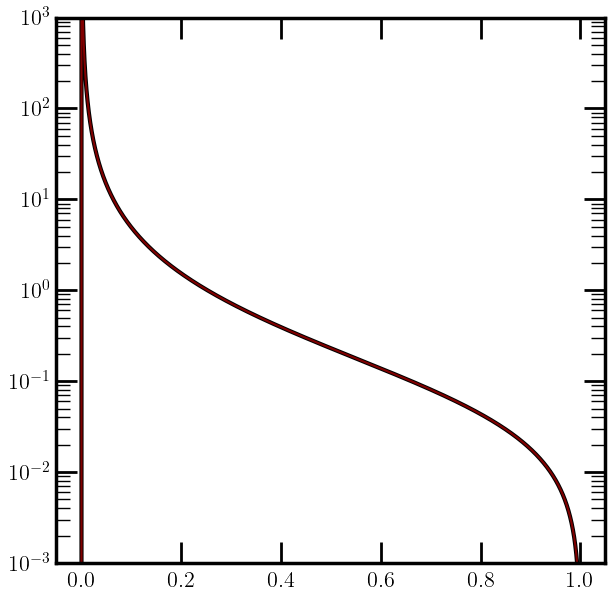

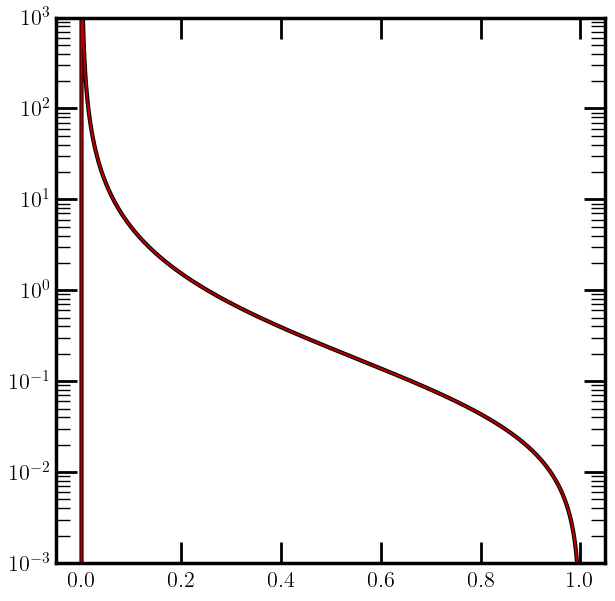

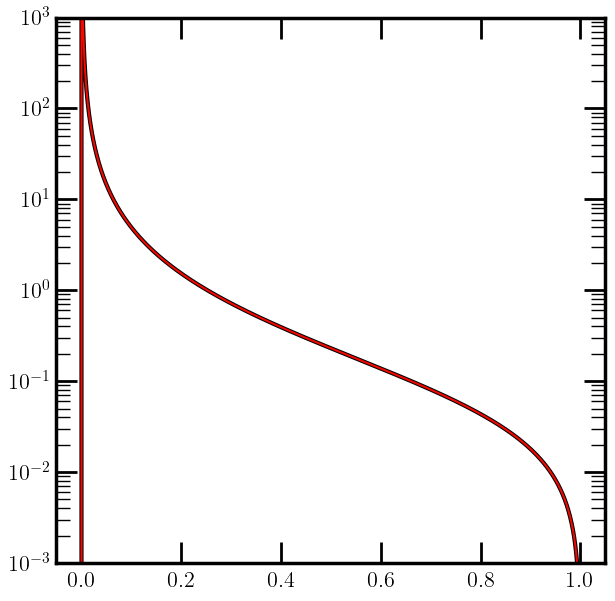

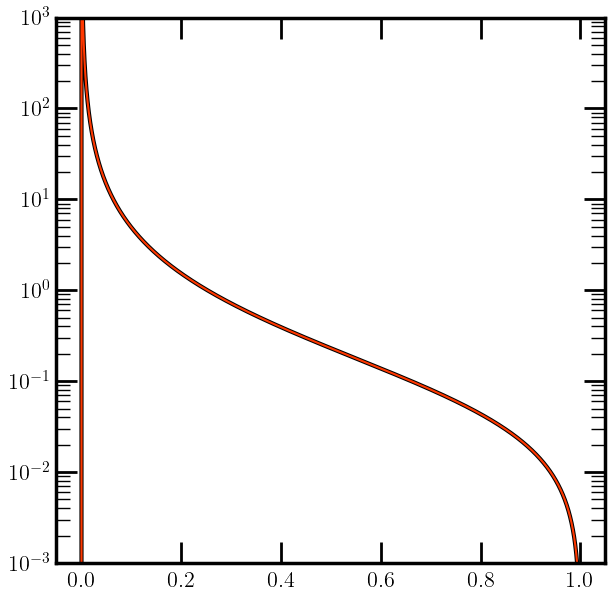

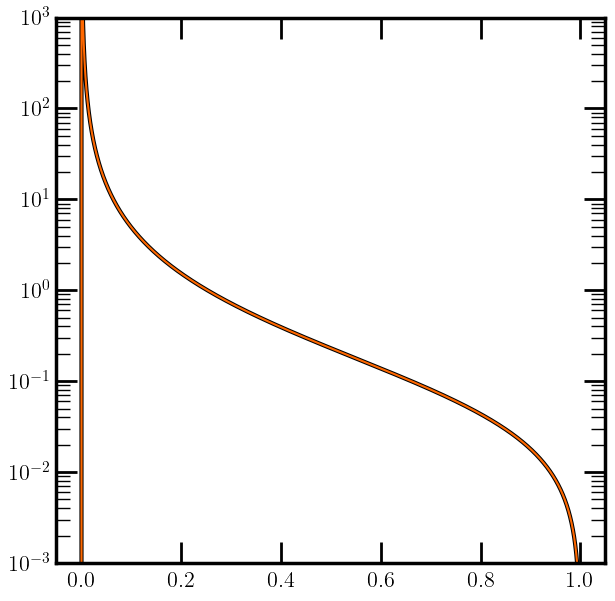

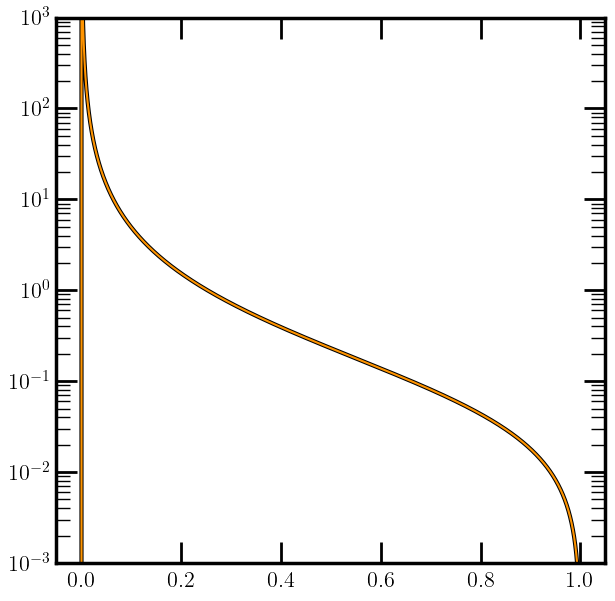

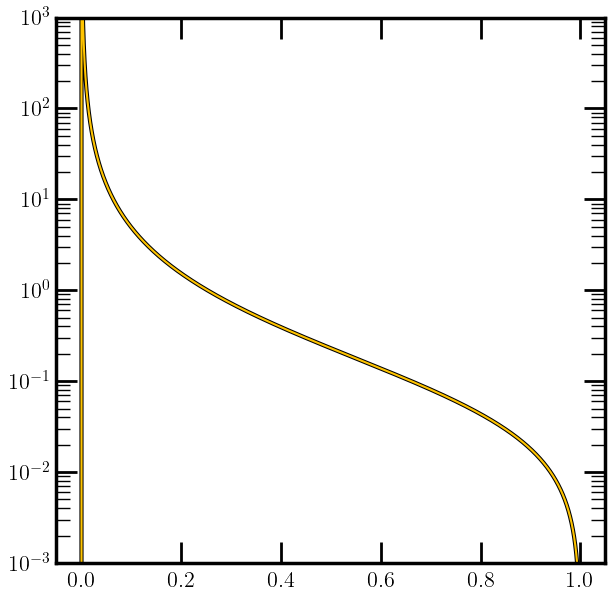

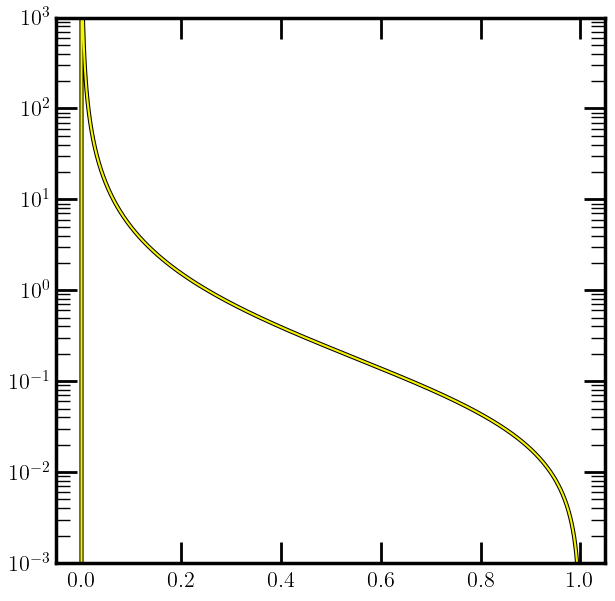

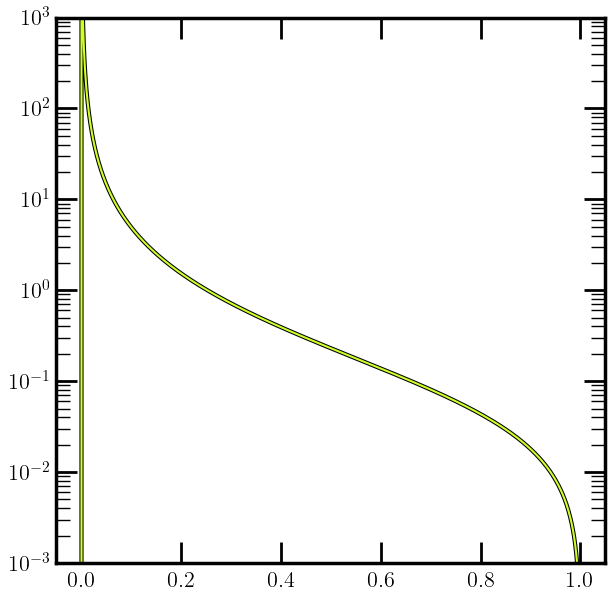

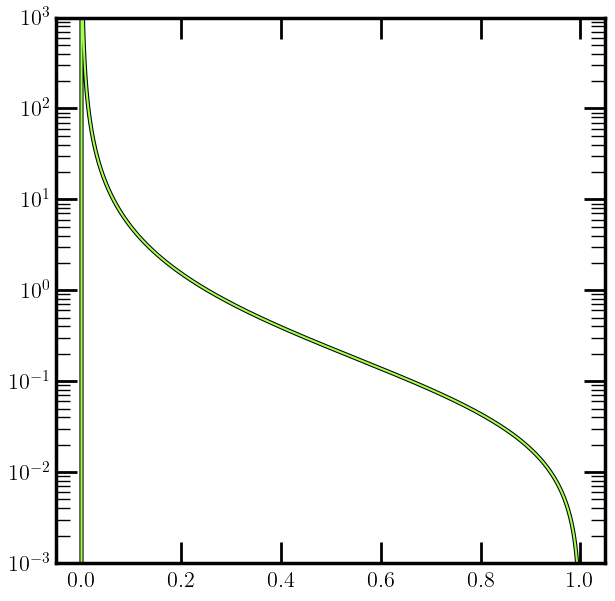

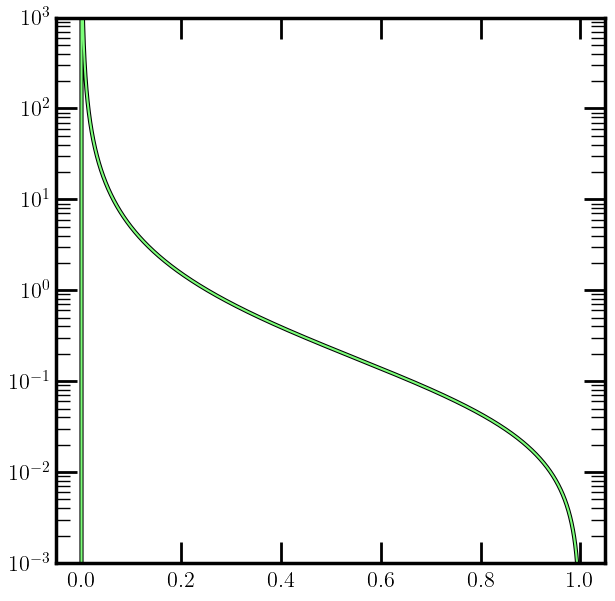

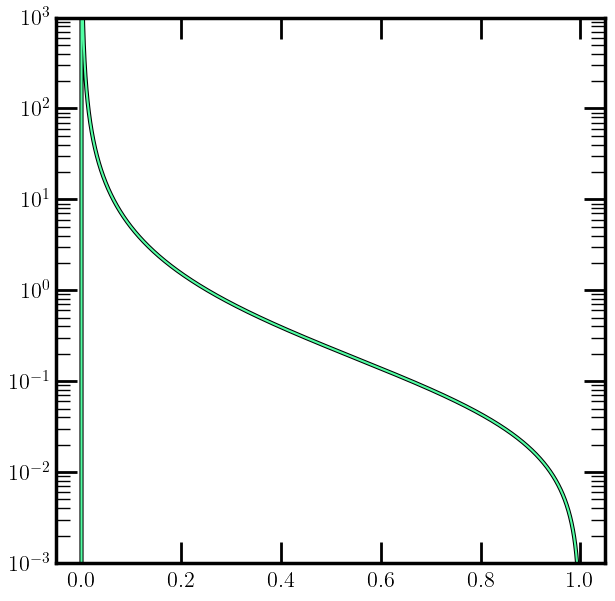

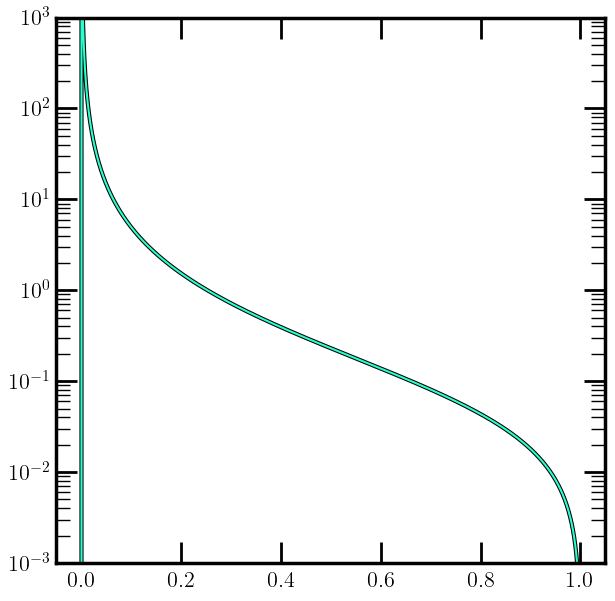

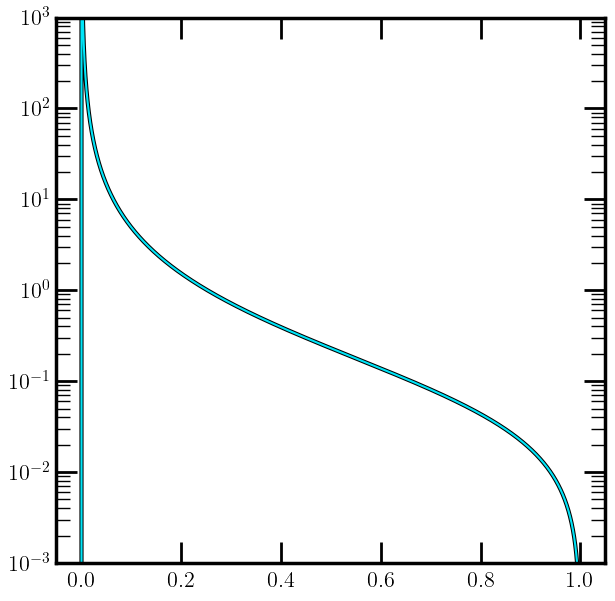

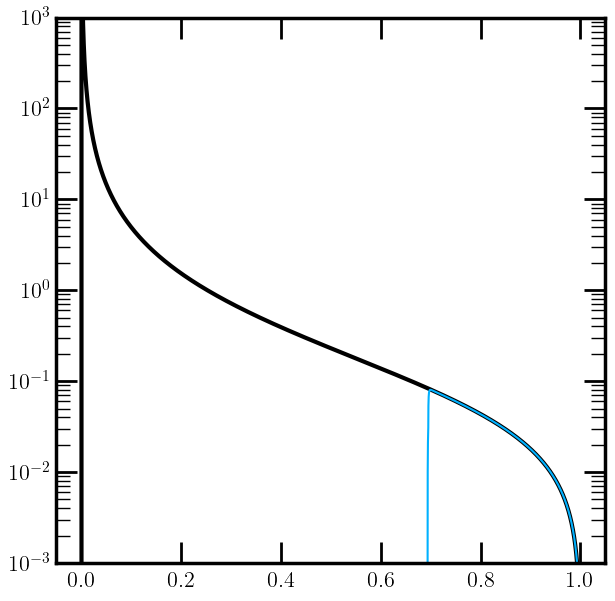

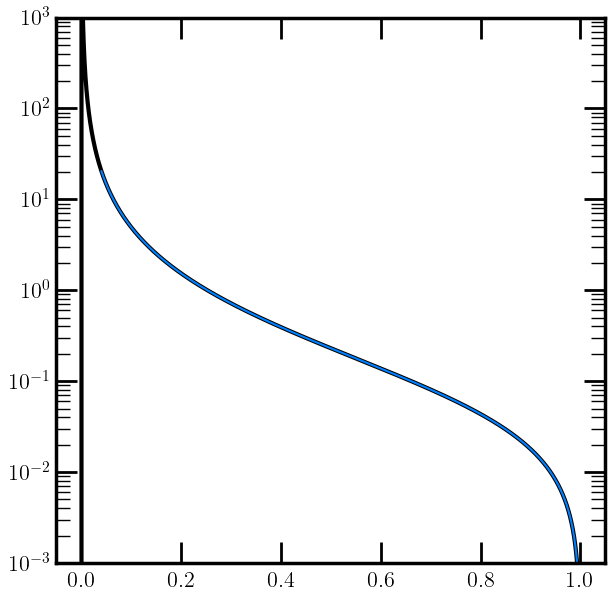

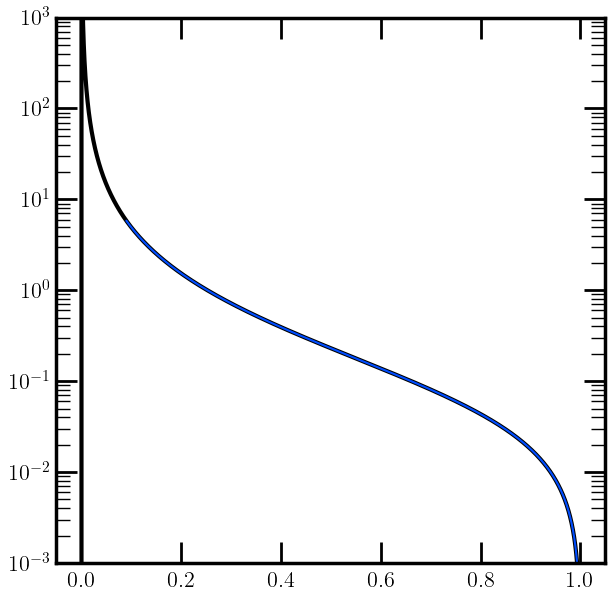

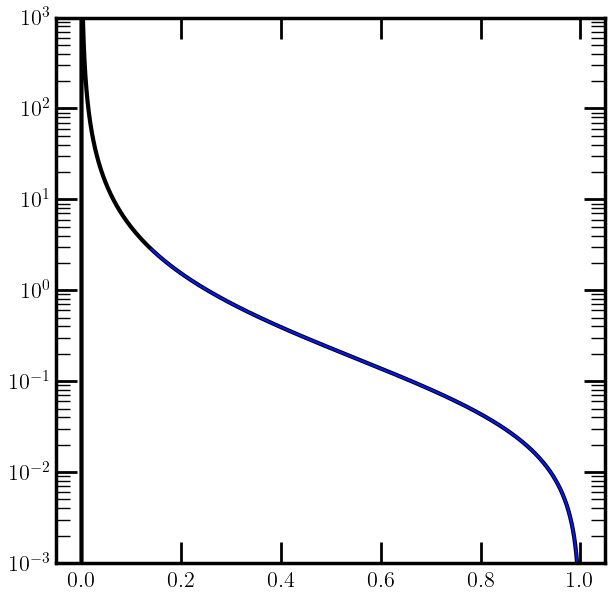

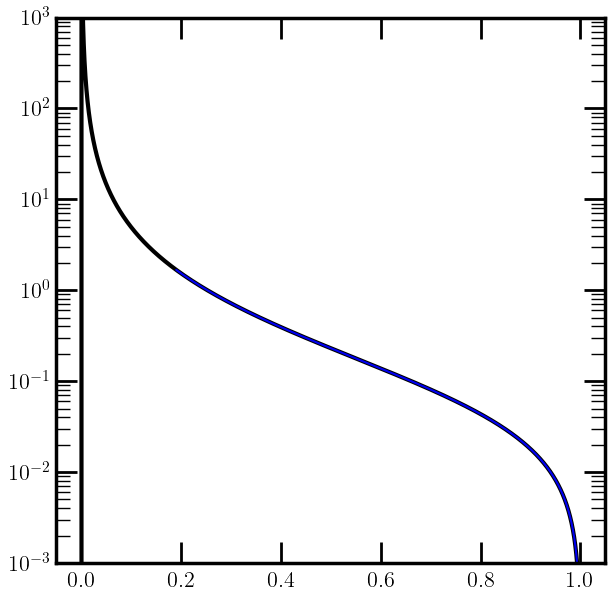

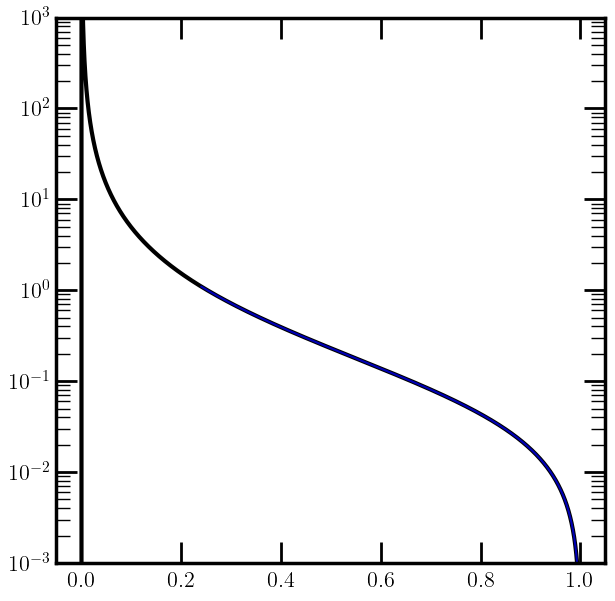

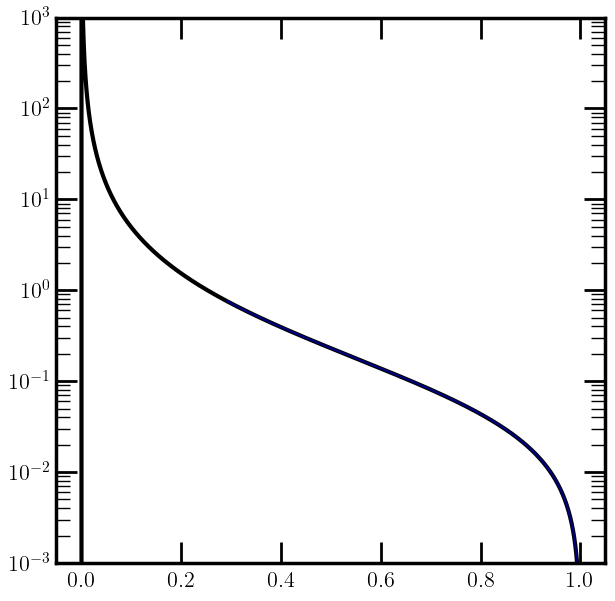

In [22]:
import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap


cs = np.linspace(0, 1.0, 21)
colors = get_cmap("jet")

for c in cs:

    fig, ax = newplot("full")

    ax.plot(x_sorted, p_x(x_sorted), label = "p(x)", color = "black", lw = 3)




    lambda_ = find_lambda(c)
    ax.plot(x_sorted, answer(p_x, C, x_sorted, lambda_, c), label = "answer", color = colors(1-c), alpha = 1, lw = 1.5)


    ax.set_yscale("log")
# print(answer(p_x, C, x_sorted, lambda_, c))
    print(c, integral(p_x, C, x, lambda_, c))

    ax.set_ylim(1e-3, 1e3)